In [ ]:
!pip install rasterio

In [4]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
import rasterio
from rasterio.plot import show
from PIL import Image
import os

In [5]:
dataset = []
path = "C:\\Users\\rouna\\OneDrive\\Desktop\\KN\\Tb927.1.4340_c_0_0.tiff"

folder_path = "C:\\Users\\rouna\\OneDrive\\Desktop\\KN\\"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.tiff'))]
k=0
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    if(k%100==0):
        print(k)
    k+=1
    with rasterio.open(image_path) as image:
        image_array = image.read()
    dataset.append((torch.from_numpy(np.vstack(image_array).astype(np.float32)).unsqueeze(0),0))

0


D:\Anaconda\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [6]:
dataset[0][0].shape

torch.Size([1, 323, 323])

In [7]:
def subsample(img, k):
    lst = []
    for i in range(0,img.shape[0]):
        x = img[i][::k, ::k]
        lst.append(x.T)
    return np.array(lst)

C:\Users\rouna\AppData\Local\Temp\ipykernel_28972\709702173.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\aten\src\ATen\native\TensorShape.cpp:2985.)
  plt.imshow(dataset[40][0].T, cmap="gray")


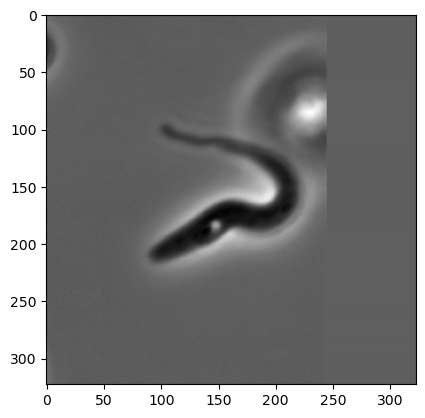

In [8]:
plt.imshow(dataset[40][0].T, cmap="gray")

In [9]:
lst_img = []

for i in range(50):
    lst_img.append(np.array(dataset[i][0].T))

lst_img = np.array(lst_img)

In [10]:
lst_img.shape

(50, 323, 323, 1)

In [11]:
lst_of_img_reduced = []
loss_lst = []

lst_of_img_damn = None
for i in range(1,30):
    loss_lst.append(0)
for k in range(1,30):
    lst_of_img_damn = subsample(lst_img, k)
    latest_img = torch.from_numpy(lst_of_img_damn).float()
    img_interpolated = F.interpolate(latest_img,(323,323), mode='bilinear')
    for i in range(dataset[0][0].shape[0]):
        img = lst_img[i]
        img_int = img_interpolated[i].T
        diff_img = np.array(img )- np.array(img_int)
        loss_lst[k-1]+=(np.linalg.norm(diff_img))

In [12]:
img_interpolated.shape

torch.Size([50, 1, 323, 323])

[ 0.          0.62335746  1.01361352  1.71876563  1.8017825   3.06755969
  2.48710047  2.42202922  4.91158406  2.94942719  3.59002125  5.94888125
  5.5311075   4.80977781  5.34774562  4.79767656  7.88491312  8.39563875
  8.54648187  5.60462875  6.23097375  7.09185812  7.25561875  7.16013875
  8.84422688  7.24852125 10.16582625  7.67912687  7.72649063]


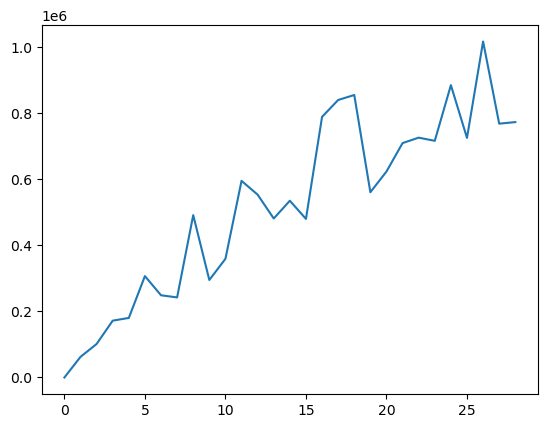

In [13]:
print(np.array(loss_lst)/1e5)
plt.plot(loss_lst)

In [16]:

def normalize_gray_images(images):
    mean = images.mean()
    std = images.std()
    normalized_images = (images - mean) / std

    return normalized_images


In [14]:
dataset_compressed = []

for i in range(np.array(dataset).shape[0]):
    dataset_compressed.append(np.float32(np.array(dataset[i][0].T)))

dataset_compressed = np.array(dataset_compressed)

dataset_compressed = subsample(dataset_compressed, 4)

dataset_compressed = np.array(dataset_compressed)
dataset_compressed.shape

C:\Users\rouna\AppData\Local\Temp\ipykernel_28972\4122577112.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  for i in range(np.array(dataset).shape[0]):
C:\Users\rouna\AppData\Local\Temp\ipykernel_28972\4122577112.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i in range(np.array(dataset).shape[0]):


(5067, 1, 81, 81)

In [20]:
dataset_compressed = normalize_gray_images(np.float32(np.array(dataset_compressed)))

In [27]:
dataset_final = []
for i in range(5067):
    img_arr = dataset_compressed[i]
    img_arr = img_arr[:, :80, :80]
    dataset_final.append((torch.from_numpy(np.vstack(img_arr).astype(np.float32)).unsqueeze(0),0))


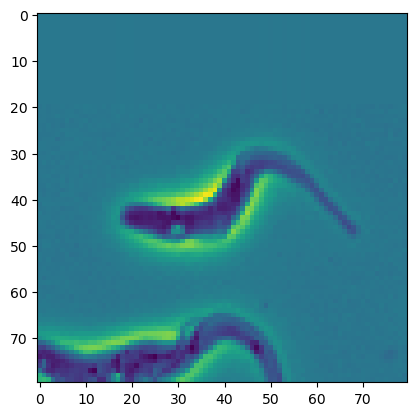

In [28]:
plt.imshow(dataset_final[0][0].T)

In [29]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels), 
            nn.GELU(), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:  
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [30]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels), 
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        return self.model(torch.cat((x, skip), 1))


In [31]:

class EmbedFC(nn.Module):
    def __init__(self, input_dim , emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim).to(device)
        return self.model(x)

In [32]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4), 
            nn.GroupNorm(8, 2 * n_feat),                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [88]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 4*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 2, 2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down3)
        up3 = self.up2(cemb2*up2 + temb2, down2)
        up4 = self.up3(cemb3*up3 + temb3, down1)
        out = self.out(torch.cat((up4, x), 1))
        return out


In [33]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [34]:
timesteps = 300
beta1 = 1e-4
beta2 = 0.02


device="cuda" if torch.cuda.is_available() else "cpu"
n_feat = 256 
n_cfeat = 10 
height = 32 
save_dir = './weight_nn/'

batch_size = 50
n_epoch = 2000
lrate=1e-3

In [35]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [36]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [131]:
s=0.008
f = (torch.cos((torch.linspace(0, timesteps, timesteps + 1)/timesteps+s)/(1+s) * torch.asin(torch.tensor(1))))**2
ab_t = f/(torch.cos((s)/(1+s) * torch.asin(torch.tensor(1))))**2
b_t = []
for i in range(1, timesteps):
    b_t.append(1-ab_t[i]/ab_t[i-1])
b_t = torch.tensor(b_t)
a_t = 1 - b_t
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [37]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [38]:
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [39]:
nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_cfeat=n_cfeat).to(device)
optim = torch.optim.SGD(nn_model.parameters(), lr=lrate)

In [40]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [41]:
dataloader = DataLoader(dataset_final, batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [42]:
dataset[0][0].shape

torch.Size([1, 323, 323])

In [43]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [44]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise, device=device):
    final = ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise
    final = final.to(device)
    return final

In [45]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [46]:
# define sampling function for DDIM   
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]
    
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [47]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, context, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [48]:
def make_encoding(x, n_samples=batch_size, n_classes=n_cfeat):
    encode = [
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
    ]
    final = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        final[i] = encode[x[i].int()]
    final = torch.tensor(final).float().to(device)
    return final

In [49]:
loss_train  = []

In [50]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
    plt.show()

In [51]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [ ]:
checkpoint = torch.load(f"{save_dir}nn_model1240.pth", map_location = device)
epoch = checkpoint['epoch']
optim.load_state_dict(checkpoint['optimizer_state_dict'])
nn_model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
import os
nn_model.train()


for ep in range(0, n_epoch):
    print("allocated mem -", torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9)
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = lrate/10*(1-0.2*ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    #print(pbar)
    #break
    #k=0
    loss_val = 0
    for x,_ in pbar:
        optim.zero_grad()
        x=x.to(device)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise = nn_model(x_pert, t/timesteps, c=None)
        loss = F.mse_loss(pred_noise, noise)
        loss_values_1.append(loss.item())
        loss_val+=loss
        loss.backward()
        optim.step()
    if(ep%10==0):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model{ep}.pth"))
        print("Saved model at " + str(save_dir+f"nn_model{ep}.pth"))
    

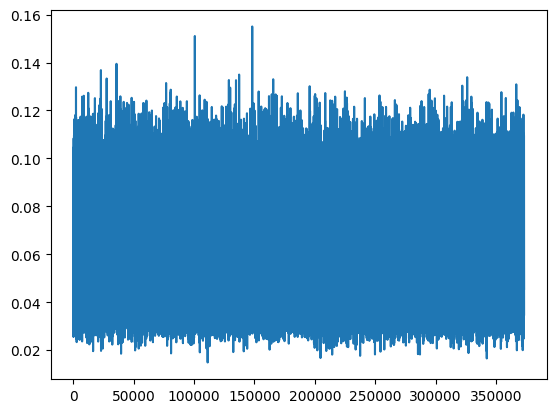

In [115]:
loss_values_1 = torch.tensor(loss_values_1).cpu()
plt.plot(np.array(loss_values_1))
loss_values_1 = loss_values_1.tolist()

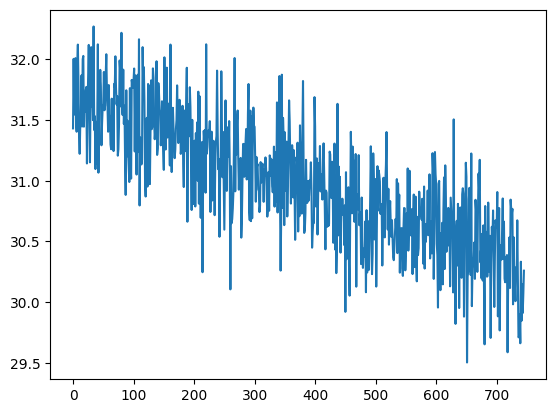

In [114]:
loss_values_1 = np.asarray(loss_values_1)
sum1=0
loss_values_epoch=[]
for i in range(1, loss_values_1.shape[0]):
    sum1+=loss_values_1[i]
    if(i%500==0):
        loss_values_epoch.append(sum1)
        sum1=0
loss_values_epoch = np.asarray(loss_values_epoch)
plt.plot(loss_values_epoch)

In [90]:
loss_values_1.shape

torch.Size([364738])

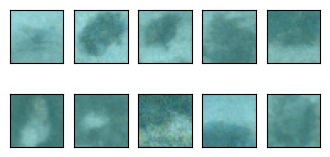

In [88]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
import os
nn_model.train()
guide_w = 0.3
loss_values_2=[]
for ep in range(n_epoch):
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    for x, c in pbar:
        optim.zero_grad()
        x=x.to(device)
        c=c.to(device)
        c=make_encoding(c)
    #print(c.shape)
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        
    #print(c.shape)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise_2 = nn_model(x_pert, t/timesteps, c=None)
        pred_noise_1 = nn_model(x_pert, t/timesteps, c)
        pred_noise_final = eps = (1+guide_w)*pred_noise_1 - guide_w*pred_noise_2
        loss = F.mse_loss(pred_noise_final, noise)
        loss_values_2.append(loss)
        loss.backward()
        optim.step()
    

In [ ]:
loss_values_2 = torch.tensor(loss_values_2).cpu()
plt.plot(np.array(loss_values_2)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], None)
show_images(samples)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
#animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
#HTML(animation_ddpm_context.to_jshtml())